# Import Libraries

In [1]:
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import os

2024-12-15 12:02:49.312338: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1734282169.323933   36337 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1734282169.327174   36337 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-15 12:02:49.339443: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Load Dataset

In [2]:
train_dataset_path = 'Covid19-dataset/train/'
test_dataset_path = 'Covid19-dataset/test/'

In [3]:
train_data_generator = ImageDataGenerator(
    rescale=1/255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

test_data_generator = ImageDataGenerator(
    rescale=1/255
)

train_data_images = train_data_generator.flow_from_directory(
    train_dataset_path,
    target_size=(256, 256),
    batch_size=16,
    class_mode=None
)

train_data = train_data_generator.flow_from_directory(
    train_dataset_path,
    target_size=(256, 256),
    batch_size=16,
    class_mode='categorical'
)

test_data_images = test_data_generator.flow_from_directory(
    test_dataset_path,
    target_size=(256, 256),
    batch_size=16,
    class_mode=None,
    shuffle=False
)

test_data = test_data_generator.flow_from_directory(
    test_dataset_path,
    target_size=(256, 256),
    batch_size=1,
    class_mode='categorical',
    shuffle=False
)

Found 251 images belonging to 3 classes.
Found 251 images belonging to 3 classes.
Found 66 images belonging to 3 classes.
Found 66 images belonging to 3 classes.


In [4]:
print("Class indices:", train_data.class_indices)

Class indices: {'Covid': 0, 'Normal': 1, 'Viral Pneumonia': 2}


# Autoencoder Setup

In [5]:
# Wrap train and test data generators for autoencoder
def autoencoder_generator(generator):
    for batch in generator:
        yield (batch, batch)

train_gen = autoencoder_generator(train_data_images)
test_gen = autoencoder_generator(test_data_images)

In [6]:
# Autoencoder Model
input_img = Input(shape=(256, 256, 3))

# Encoder
x = Conv2D(64, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)

# Bottleneck
encoded = Conv2D(16, (3, 3), activation='relu', padding='same')(x)

# Decoder
x = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.summary()

2024-12-15 12:02:51.416115: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 256, 256, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 128, 32)   │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 64, 64, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 128, 128, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 256, 256, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 256, 256, 3)    │         1,731 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 49,747 (194.32 KB)

 Trainable params: 49,747 (194.32 KB)

 Non-trainable params: 0 (0.00 B)

# Train Autoencoder

In [7]:
# Train Autoencoder
autoencoder.fit(
    train_gen,
    steps_per_epoch=len(train_data_images),
    validation_data=test_gen,
    validation_steps=len(test_data_images),
    epochs=5
)

# Feature Extraction using Encoder
encoder = Model(input_img, encoded)

Epoch 1/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - loss: 0.0781 - val_loss: 0.0413
Epoch 2/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - loss: 0.0350 - val_loss: 0.0141
Epoch 3/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - loss: 0.0095 - val_loss: 0.0067
Epoch 4/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - loss: 0.0046 - val_loss: 0.0053
Epoch 5/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - loss: 0.0037 - val_loss: 0.0046


# CNN Classifier Setup

In [ ]:
classifier_input = Input(shape=(256, 256, 3))
features = encoder(classifier_input)
x = Flatten()(features)
x = Dense(128, activation='relu')(x)
x = Dense(128, activation='relu')(x)
output = Dense(3, activation='softmax')(x)

cnn_model = Model(classifier_input, output)
cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
cnn_model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_1 (Functional)       │ (None, 64, 64, 16)     │        24,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 65536)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     8,388,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,430,515 (32.16 MB)

 Trainable params: 8,430,515 (32.16 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
# Train CNN Classifier
cnn_history = cnn_model.fit(
    train_data,
    epochs=5,
    validation_data=test_data,
    validation_steps=len(test_data)
)

/home/mavwdj/.pyenv/versions/ml-env/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 688ms/step - accuracy: 0.4295 - loss: 3.6441 - val_accuracy: 0.6364 - val_loss: 0.9274
Epoch 2/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 11s 671ms/step - accuracy: 0.5310 - loss: 0.9328 - val_accuracy: 0.7273 - val_loss: 0.7010
Epoch 3/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 11s 669ms/step - accuracy: 0.6265 - loss: 0.7446 - val_accuracy: 0.5455 - val_loss: 0.8698
Epoch 4/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 11s 665ms/step - accuracy: 0.7228 - loss: 0.6866 - val_accuracy: 0.5909 - val_loss: 0.7347
Epoch 5/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 11s 655ms/step - accuracy: 0.6630 - loss: 0.6975 - val_accuracy: 0.6667 - val_loss: 0.7212


# Visualize Training Results

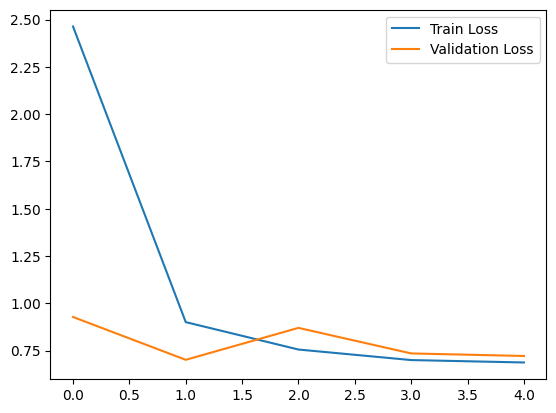

In [11]:
plt.plot(cnn_history.history['loss'], label='Train Loss')
plt.plot(cnn_history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

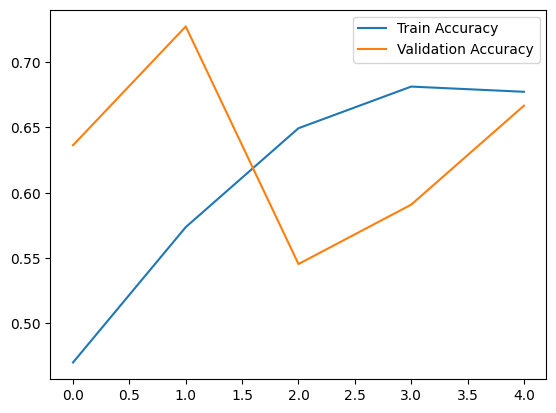

In [12]:
plt.plot(cnn_history.history['accuracy'], label='Train Accuracy')
plt.plot(cnn_history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.show()

In [13]:
cnn_model.evaluate(test_data)

66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8151 - loss: 0.4611


[0.7212138175964355, 0.6666666865348816]

# Evaluate Model

In [14]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Step 1: Predict on test data
test_data.reset()  # Reset test data generator to avoid data order issues
predictions = cnn_model.predict(test_data, steps=len(test_data), verbose=1)

# Step 2: Convert predictions to class labels
predicted_classes = np.argmax(predictions, axis=1)

# Step 3: Get ground-truth labels
true_classes = test_data.classes  # True class labels from the generator
class_labels = list(test_data.class_indices.keys())  # Class names

# Step 4: Classification report
print("Classification Report:")
print(classification_report(true_classes, predicted_classes, target_names=class_labels))

# Optional: Confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(true_classes, predicted_classes))


66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
Classification Report:
                 precision    recall  f1-score   support

          Covid       0.93      1.00      0.96        26
         Normal       0.50      0.05      0.09        20
Viral Pneumonia       0.47      0.85      0.61        20

       accuracy                           0.67        66
      macro avg       0.63      0.63      0.55        66
   weighted avg       0.66      0.67      0.59        66

Confusion Matrix:
[[26  0  0]
 [ 0  1 19]
 [ 2  1 17]]
